# Demand Response Baseline Models: Tutorial

This notebook provides a comprehensive guide to developing and validating baseline models 
for demand response (DR) programs in commercial buildings. We provide 11 commerical office buildings that participated demand response program in 2020.

## Learning Objectives

By the end of this tutorial, you will be able to:
1. Load and preprocess building energy and weather data
2. Implement multiple baseline calculation methods
3. Validate baseline model accuracy
4. Calculate DR performance metrics
5. Generate professional visualizations
6. Export results for reporting


## Core Classes

1. DRDataProcessor - Handles data loading and preprocessing
2. BaselineModels - Implements various baseline calculation methods
3. PerformanceAnalyzer - Calculates DR performance metrics
4. DRVisualizer - Creates plots and visualizations

## Required Data Files

1. Meter Data (meter-data/{site_id}.csv)

Timestamp-indexed power consumption data
Columns: power (kW)


2. Weather Data (weatherdata/{location}_Weather.csv)

Hourly temperature data
Columns: temperature (°C)


3. DR Events (dr-event-new.csv)

Event schedules and metadata
Columns: site, event_date, event_type, shed_start_time, shed_end_time, etc.


4. Holidays (holiday.csv)

List of holidays to exclude from baseline
Columns: date


5. Site Information (sites-new.csv)

Building metadata
Columns: site_id, floor_area, etc.

## Baseline Models {#baseline-models}
1. X-of-Y Average Baseline with Adjustment
This is the most common method used in DR programs:

Select Y recent valid days (e.g., 10 weekdays)
Choose highest X days by peak demand (e.g., top 10)
Calculate hourly averages across these X days
Apply adjustment factor based on pre-event hours

2. Weather-Matched Baseline
Selects the baseline day with weather most similar to the DR event day:

Calculate temperature differences between event day and candidate baseline days
Select day with minimum squared differences
Use that day's load profile as baseline

3. Outside Air Temperature (OAT) Regression
Develops statistical models relating power consumption to temperature:

Train hourly regression models for each hour of the day
Predict baseline using event day weather conditions

In [1]:
# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.gridspec as gridspec
import seaborn as sns
from datetime import datetime, timedelta
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union
import logging
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [20]:
class DRDataProcessor:
    """
    Handles loading and preprocessing of demand response analysis data.
    
    This class manages meter data, weather data, holiday information, and DR events,
    ensuring data quality and consistency for baseline modeling.
    """
    
    def __init__(self, site_config: Dict):
        """
        Initialize the data processor.
        
        Args:
            site_config: Dictionary containing site information including:
                - site_id: Unique identifier for the building
                - floor_area: Building floor area in sq ft
                - Other metadata
        """
        self.site_config = site_config
        self.site_id = site_config['site_id']
        self.root_dir = Path.cwd()
        self.data_dir = self.root_dir / 'data' / 'chapter2'
        self.output_dir = self.data_dir / 'output' / self.site_id
        self.plot_dir = self.data_dir / 'plot' / self.site_id
        
        # Create output directories
        for directory in [self.output_dir, self.plot_dir]:
            directory.mkdir(parents=True, exist_ok=True)
        
        # Initialize data containers
        self.meter_data = None
        self.weather_data = None
        self.holidays = None
        self.dr_events = None
        self.processed_data = None
        
    def load_holiday_data(self) -> pd.DataFrame:
        """Load and process holiday data."""
        try:
            holidays_file = self.data_dir / 'holidays-new.csv'
            holidays = pd.read_csv(holidays_file, usecols=[0])
            holidays['date'] = pd.to_datetime(holidays['date'], format='%m/%d/%y')
            holidays['day'] = holidays['date'].dt.strftime('%Y-%m-%d')
            logger.info(f"Loaded {len(holidays)} holidays")
            return holidays
        except Exception as e:
            logger.error(f"Error loading holiday data: {e}")
            return pd.DataFrame(columns=['date', 'day'])
    
    def load_dr_events(self) -> pd.DataFrame:
        """Load and process DR event data."""
        try:
            events_file = self.data_dir / 'dr-event-new.csv'
            dr_events = pd.read_csv(events_file)
            
            # Convert date columns
            dr_events['event_date'] = pd.to_datetime(dr_events['event_date'], format='%m/%d/%y')
            dr_events['date'] = dr_events['event_date'].dt.strftime('%Y-%m-%d')
            
            # Filter events for this site
            site_events = dr_events[dr_events['site'] == self.site_id].copy()
            logger.info(f"Loaded {len(site_events)} DR events for site {self.site_id}")
            return site_events
        except Exception as e:
            logger.error(f"Error loading DR event data: {e}")
            return pd.DataFrame()
    
    def load_meter_data(self) -> pd.DataFrame:
        """Load and process meter data."""
        try:
            meter_file = self.data_dir / f'meter-data/{self.site_id}.csv'
            df = pd.read_csv(meter_file, index_col=0, parse_dates=True)
            
            # Handle missing data
            df = df.fillna(method='ffill').fillna(method='bfill')
            
            # Remove duplicate timestamps
            df = df[~df.index.duplicated(keep='first')]
            
            # Add time-based features
            df['date'] = df.index
            df['time'] = df.index.strftime('%H:%M')
            df['day'] = df.index.strftime('%Y-%m-%d')
            df['hour'] = df.index.hour
            df['weekday'] = df.index.weekday  # 0=Monday, 6=Sunday
            df['month'] = df.index.month
            
            logger.info(f"Loaded meter data: {len(df)} records from {df.index.min()} to {df.index.max()}")
            return df
        except Exception as e:
            logger.error(f"Error loading meter data: {e}")
            raise
    
    def load_weather_data(self) -> pd.Series:
        """Load and process weather data."""
        try:
            weather_file = self.data_dir / 'weatherdata/SanBernadino_2018-01-01_2020-01-01_Weather.csv'
            df = pd.read_csv(weather_file, index_col=0, parse_dates=True)
            
            # Convert temperature to Fahrenheit
            df['oat'] = df['temperature'] * 1.8 + 32
            
            # Handle missing data and duplicates
            df = df.fillna(method='ffill').fillna(method='bfill')
            df = df[~df.index.duplicated(keep='last')]
            
            # Resample to 15-minute intervals
            oat_series = df['oat'].resample('15min').interpolate(method='linear')
            
            logger.info(f"Loaded weather data: {len(oat_series)} records")
            return oat_series
        except Exception as e:
            logger.error(f"Error loading weather data: {e}")
            # Return empty series if weather data unavailable
            return pd.Series(dtype=float, name='oat')
    
    def create_processed_dataset(self) -> pd.DataFrame:
        """Create a processed dataset with all relevant features."""
        # Merge meter and weather data
        merged_data = pd.concat([self.meter_data, self.weather_data], axis=1, join='inner')
        
        # Add DR event flags
        dr_dates = set(self.dr_events['date'].values) if not self.dr_events.empty else set()
        merged_data['DR'] = merged_data['day'].isin(dr_dates).astype(int)
        
        # Add holiday flags
        holiday_dates = set(self.holidays['day'].values) if not self.holidays.empty else set()
        merged_data['holiday'] = merged_data['day'].isin(holiday_dates).astype(int)
        
        # Define valid baseline days (weekdays, non-holidays, non-DR days)
        merged_data['valid_dates'] = (
            (merged_data['weekday'] < 5) &  # Monday-Friday
            (merged_data['holiday'] == 0) &
            (merged_data['DR'] == 0)
        ).astype(int)
        
        logger.info(f"Created processed dataset with {len(merged_data)} records")
        return merged_data
    
    def load_all_data(self):
        """Load all required data and create processed dataset."""
        logger.info("Loading all data...")
        self.holidays = self.load_holiday_data()
        self.dr_events = self.load_dr_events()
        self.meter_data = self.load_meter_data()
        self.weather_data = self.load_weather_data()
        self.processed_data = self.create_processed_dataset()
        logger.info("Data loading completed successfully")
    
    def get_processed_data(self) -> pd.DataFrame:
        """Return the processed dataset."""
        if self.processed_data is None:
            raise ValueError("Data not loaded. Call load_all_data() first.")
        return self.processed_data
    
    def get_event_by_date(self, event_date: str) -> Optional[Dict]:
        """Get DR event information for a specific date."""
        if self.dr_events.empty:
            return None
        
        event_row = self.dr_events[self.dr_events['date'] == event_date]
        if event_row.empty:
            return None
        
        return event_row.iloc[0].to_dict()
    
    def calculate_load_statistics(self) -> pd.Series:
        """Calculate building load statistics for benchmarking."""
        if self.processed_data is None:
            raise ValueError("Data not loaded. Call load_all_data() first.")
        
        # Filter to 2019 data and resample to hourly
        year_data = self.processed_data[self.processed_data.index.year == 2019]
        hourly_data = year_data[['power', 'oat', 'month']].resample('1H').mean()
        
        # Separate occupied and unoccupied hours
        occupied = hourly_data[
            (hourly_data.index.hour >= 7) & 
            (hourly_data.index.hour < 23) & 
            (hourly_data.index.weekday < 5)
        ]
        
        unoccupied = hourly_data[~hourly_data.index.isin(occupied.index)]
        
        # Calculate statistics
        stats = pd.Series({
            'Annual Electric Consumption (kWh)': hourly_data['power'].sum(),
            'Peak Electric Demand Summer (kW)': hourly_data[hourly_data['month'].isin([6, 7, 8])]['power'].max(),
            'Peak Electric Demand Winter (kW)': hourly_data[hourly_data['month'].isin([12, 1, 2])]['power'].max(),
            'Annual Average EUI (kWh/sf)': hourly_data['power'].sum() / float(self.site_config['floor_area']),
            'Peak Demand Intensity (W/sf)': hourly_data['power'].max() * 1000 / float(self.site_config['floor_area']),
            'Weather Sensitivity Occupied': occupied[['oat', 'power']].corr().iloc[0, 1],
            'Weather Sensitivity Unoccupied': unoccupied[['oat', 'power']].corr().iloc[0, 1],
            'Top 50 Hours Threshold (kW)': hourly_data['power'].nlargest(50).iloc[-1]
        })
        
        return stats


In [15]:
class BaselineModels:
    """
    Implements various baseline modeling approaches for demand response analysis.
    
    This class provides methods to calculate different types of baselines:
    - X-of-Y average baseline with adjustment
    - Weather-matched baseline
    - OAT regression baseline
    """
    
    def __init__(self, data: pd.DataFrame, site_config: Dict):
        """
        Initialize baseline models.
        
        Args:
            data: Processed building data with meter, weather, and event information
            site_config: Site configuration dictionary
        """
        self.data = data
        self.site_config = site_config
        
    def select_baseline_days(self, event_date: datetime, x_days: int = 10, y_days: int = 10) -> pd.DataFrame:
        """
        Select X highest-demand days from Y recent valid days.
        
        Args:
            event_date: Date of the DR event
            x_days: Number of days to include in baseline (typically 10)
            y_days: Number of recent days to consider (typically 10)
            
        Returns:
            DataFrame containing selected baseline days
        """
        # Get training period (30 days before event, excluding event day)
        train_start = event_date - timedelta(days=30)
        train_end = event_date - timedelta(days=1)
        
        # Filter to valid baseline days only
        valid_data = self.data[
            (self.data.index >= train_start) & 
            (self.data.index <= train_end) &
            (self.data['valid_dates'] == 1)
        ]
        
        if valid_data.empty:
            logger.warning(f"No valid baseline days found for {event_date}")
            return pd.DataFrame()
        
        # Get Y most recent valid days
        recent_days = sorted(valid_data['day'].unique())[-y_days:]
        recent_data = valid_data[valid_data['day'].isin(recent_days)]
        
        # Select X days with highest peak demand
        daily_peaks = recent_data.groupby('day')['power'].max().sort_values(ascending=False)
        selected_days = daily_peaks.head(x_days).index.tolist()
        
        baseline_data = recent_data[recent_data['day'].isin(selected_days)]
        
        logger.info(f"Selected {len(selected_days)} baseline days from {len(recent_days)} candidates")
        return baseline_data
    
    def calculate_average_baseline_with_adjustment(
        self, 
        event_date: str, 
        x_days: int = 10, 
        y_days: int = 10, 
        adjustment_limit: float = 0.2
    ) -> pd.DataFrame:
        """
        Calculate X-of-Y average baseline with morning adjustment.
        
        This is the standard baseline method used in most DR programs.
        
        Args:
            event_date: Date of DR event (YYYY-MM-DD format)
            x_days: Number of baseline days to average
            y_days: Number of recent days to consider
            adjustment_limit: Maximum allowed adjustment factor (e.g., 0.2 = ±20%)
            
        Returns:
            DataFrame with baseline and actual power data for the event day
        """
        event_dt = datetime.strptime(event_date, '%Y-%m-%d')
        
        # Select baseline days
        baseline_data = self.select_baseline_days(event_dt, x_days, y_days)
        
        if baseline_data.empty:
            raise ValueError(f"No baseline data available for {event_date}")
        
        # Get event day data
        event_data = self.data[self.data['day'] == event_date].copy()
        
        if event_data.empty:
            raise ValueError(f"No event day data available for {event_date}")
        
        # Calculate average baseline by time of day
        avg_baseline = baseline_data.groupby('time')['power'].mean()
        
        # Add baseline to event day data
        event_data['avg_baseline'] = event_data['time'].map(avg_baseline)
        
        # Calculate adjustment factor using morning hours (typically 2-5 hours before event)
        # This accounts for day-of differences between baseline and actual consumption
        adjustment_hours = event_data[
            (event_data.index.hour >= 9) & (event_data.index.hour <= 12)
        ]
        
        if not adjustment_hours.empty and not adjustment_hours['avg_baseline'].isna().all():
            adjustment_factor = (
                adjustment_hours['power'].mean() / 
                adjustment_hours['avg_baseline'].mean()
            )
            
            # Limit adjustment factor to prevent extreme corrections
            adjustment_factor = np.clip(
                adjustment_factor, 
                1 - adjustment_limit, 
                1 + adjustment_limit
            )
        else:
            adjustment_factor = 1.0
            logger.warning(f"Could not calculate adjustment factor for {event_date}, using 1.0")
        
        # Apply adjustment to baseline
        event_data['baseline'] = event_data['avg_baseline'] * adjustment_factor
        
        logger.info(f"Calculated baseline for {event_date} with adjustment factor {adjustment_factor:.3f}")
        
        return event_data[['power', 'oat', 'avg_baseline', 'baseline']]
    
    def calculate_weather_matched_baseline(
        self, 
        event_date: str, 
        x_days: int = 10, 
        y_days: int = 10
    ) -> pd.DataFrame:
        """
        Calculate weather-matched baseline using temperature similarity.
        
        Args:
            event_date: Date of DR event (YYYY-MM-DD format)
            x_days: Number of baseline days to consider
            y_days: Number of recent days to consider
            
        Returns:
            DataFrame with matched baseline and actual power data
        """
        event_dt = datetime.strptime(event_date, '%Y-%m-%d')
        
        # Select candidate baseline days
        baseline_data = self.select_baseline_days(event_dt, x_days, y_days)
        
        if baseline_data.empty:
            raise ValueError(f"No baseline data available for {event_date}")
        
        # Get event day data
        event_data = self.data[self.data['day'] == event_date].copy()
        
        if event_data.empty:
            raise ValueError(f"No event day data available for {event_date}")
        
        # Calculate temperature similarity for each baseline day
        temperature_differences = {}
        
        for day in baseline_data['day'].unique():
            day_data = baseline_data[baseline_data['day'] == day]
            
            # Align temperatures by time
            baseline_temps = day_data.set_index('time')['oat']
            event_temps = event_data.set_index('time')['oat']
            
            # Calculate sum of squared differences
            common_times = baseline_temps.index.intersection(event_temps.index)
            if len(common_times) > 0:
                temp_diff = np.sum((baseline_temps[common_times] - event_temps[common_times]) ** 2)
                temperature_differences[day] = temp_diff
        
        if not temperature_differences:
            raise ValueError(f"Could not calculate temperature differences for {event_date}")
        
        # Select day with minimum temperature difference
        best_match_day = min(temperature_differences, key=temperature_differences.get)
        matched_data = baseline_data[baseline_data['day'] == best_match_day]
        
        # Create baseline from matched day
        baseline_profile = matched_data.set_index('time')['power']
        event_data['baseline'] = event_data['time'].map(baseline_profile)
        
        logger.info(f"Matched {event_date} with baseline day {best_match_day}")
        
        return event_data[['power', 'oat', 'baseline']]
    
    def calculate_oat_regression_baseline(self, event_date: str, training_days: int = 30) -> pd.DataFrame:
        """
        Calculate OAT regression baseline using statistical models.
        
        Args:
            event_date: Date of DR event (YYYY-MM-DD format)
            training_days: Number of days to use for training regression models
            
        Returns:
            DataFrame with regression baseline and actual power data
        """
        event_dt = datetime.strptime(event_date, '%Y-%m-%d')
        
        # Get training data
        train_start = event_dt - timedelta(days=training_days)
        train_end = event_dt - timedelta(days=1)
        
        training_data = self.data[
            (self.data.index >= train_start) & 
            (self.data.index <= train_end) &
            (self.data['valid_dates'] == 1)
        ]
        
        if training_data.empty:
            raise ValueError(f"No training data available for {event_date}")
        
        # Get event day data
        event_data = self.data[self.data['day'] == event_date].copy()
        
        if event_data.empty:
            raise ValueError(f"No event day data available for {event_date}")
        
        # Train hourly regression models
        baseline_predictions = []
        
        for hour in range(24):
            hour_training = training_data[training_data['hour'] == hour]
            hour_event = event_data[event_data['hour'] == hour]
            
            if len(hour_training) < 3 or hour_event.empty:
                # Not enough training data for this hour
                baseline_predictions.extend([np.nan] * len(hour_event))
                continue
            
            # Fit linear regression model
            X = hour_training[['oat']].values
            y = hour_training['power'].values
            
            model = LinearRegression()
            model.fit(X, y)
            
            # Predict for event day
            X_event = hour_event[['oat']].values
            predictions = model.predict(X_event)
            baseline_predictions.extend(predictions)
        
        event_data['baseline'] = baseline_predictions
        
        # Handle any NaN predictions with interpolation
        event_data['baseline'] = event_data['baseline'].interpolate(method='linear')
        
        logger.info(f"Calculated OAT regression baseline for {event_date}")
        
        return event_data[['power', 'oat', 'baseline']]


In [16]:
class PerformanceAnalyzer:
    """
    Calculates demand response performance metrics and validation statistics.
    """
    
    def __init__(self, site_config: Dict):
        """
        Initialize performance analyzer.
        
        Args:
            site_config: Site configuration dictionary
        """
        self.site_config = site_config
        
    def calculate_baseline_validation_metrics(
        self, 
        actual: pd.Series, 
        predicted: pd.Series
    ) -> Dict[str, float]:
        """
        Calculate validation metrics for baseline accuracy.
        
        Args:
            actual: Actual power consumption values
            predicted: Predicted baseline values
            
        Returns:
            Dictionary of validation metrics
        """
        # Remove any NaN values
        mask = ~(actual.isna() | predicted.isna())
        actual_clean = actual[mask]
        predicted_clean = predicted[mask]
        
        if len(actual_clean) == 0:
            logger.warning("No valid data points for baseline validation")
            return {}
        
        # Calculate metrics
        mae = mean_absolute_error(actual_clean, predicted_clean)
        mse = mean_squared_error(actual_clean, predicted_clean)
        rmse = np.sqrt(mse)
        r2 = r2_score(actual_clean, predicted_clean)
        
        # Normalized metrics
        mean_actual = actual_clean.mean()
        nmae = mae / mean_actual if mean_actual != 0 else np.nan
        nrmse = rmse / mean_actual if mean_actual != 0 else np.nan
        
        # Bias metrics
        mbe = (predicted_clean - actual_clean).mean()
        nmbe = mbe / mean_actual if mean_actual != 0 else np.nan
        
        return {
            'MAE': mae,
            'RMSE': rmse,
            'R2': r2,
            'NMAE': nmae,
            'NRMSE': nrmse,
            'MBE': mbe,
            'NMBE': nmbe,
            'Mean_Actual': mean_actual,
            'Mean_Predicted': predicted_clean.mean(),
            'N_Points': len(actual_clean)
        }
    
    def calculate_dr_event_metrics(
        self, 
        baseline_data: pd.DataFrame, 
        event_info: Dict
    ) -> Dict[str, float]:
        """
        Calculate comprehensive DR performance metrics.
        
        Args:
            baseline_data: DataFrame with power, baseline, and oat columns
            event_info: Dictionary with event details (start/end times, type, etc.)
            
        Returns:
            Dictionary of performance metrics
        """
        df = baseline_data.copy()
        
        # Add event timing information
        df['event'] = 0  # 0=no event, 1=shed, 2=take
        
        # Parse event times
        event_type = event_info.get('event_type', 'shed')
        
        if event_type in ['shed', 'shift']:
            shed_start = datetime.strptime(event_info['shed_start_time'], '%m/%d/%y %H:%M')
            shed_end = datetime.strptime(event_info['shed_end_time'], '%m/%d/%y %H:%M')
            
            # Add 15-minute buffer for ramp-up
            shed_start_buffered = shed_start + timedelta(minutes=15)
            
            # Mark shed period
            shed_mask = (df.index >= shed_start_buffered) & (df.index <= shed_end)
            df.loc[shed_mask, 'event'] = 1
        
        if event_type in ['take', 'shift']:
            take_start = datetime.strptime(event_info['take_start_time'], '%m/%d/%y %H:%M')
            take_end = datetime.strptime(event_info['take_end_time'], '%m/%d/%y %H:%M')
            
            # Add 15-minute buffer for ramp-up
            take_start_buffered = take_start + timedelta(minutes=15)
            
            # Mark take period
            take_mask = (df.index >= take_start_buffered) & (df.index <= take_end)
            df.loc[take_mask, 'event'] = 2
        
        # Calculate power changes
        df['kW_change'] = df['baseline'] - df['power']
        df['kW_change_pct'] = (df['kW_change'] / df['baseline']) * 100
        
        # Initialize metrics
        metrics = {
            'peak_oat_day': df['oat'].max(),
            'avg_oat_event': df[df['event'].isin([1, 2])]['oat'].mean(),
            'peak_demand_intensity_wft2': df['baseline'].max() * 1000 / float(self.site_config['floor_area'])
        }
        
        # Calculate shed metrics
        shed_data = df[df['event'] == 1]
        if not shed_data.empty:
            metrics.update({
                'shed_avg_kW': shed_data['kW_change'].mean(),
                'shed_avg_wft2': shed_data['kW_change'].mean() * 1000 / float(self.site_config['floor_area']),
                'shed_avg_pct': shed_data['kW_change_pct'].mean(),
                'shed_kW_std': shed_data['kW_change'].std(),
                'shed_kW_25th': shed_data['kW_change'].quantile(0.25),
                'shed_kW_75th': shed_data['kW_change'].quantile(0.75),
                'shed_ramp_rate': shed_data['kW_change'].mean() / 15,  # kW per minute
                'shed_duration_hours': len(shed_data) / 4,  # Assuming 15-min intervals
            })
        
        # Calculate take metrics
        take_data = df[df['event'] == 2]
        if not take_data.empty:
            metrics.update({
                'take_avg_kW': take_data['kW_change'].mean(),
                'take_avg_wft2': take_data['kW_change'].mean() * 1000 / float(self.site_config['floor_area']),
                'take_avg_pct': take_data['kW_change_pct'].mean(),
                'take_kW_std': take_data['kW_change'].std(),
                'take_kW_25th': take_data['kW_change'].quantile(0.25),
                'take_kW_75th': take_data['kW_change'].quantile(0.75),
                'take_ramp_rate': take_data['kW_change'].mean() / 15,
                'take_duration_hours': len(take_data) / 4,
            })
        
        # Net energy impact
        metrics['net_energy_change_pct'] = (
            (df['power'].sum() - df['baseline'].sum()) / df['baseline'].sum() * 100
        )
        
        # Shift-specific metrics
        if event_type == 'shift' and not take_data.empty and not shed_data.empty:
            metrics['take_shed_ratio_pct'] = abs(
                take_data['kW_change'].sum() / shed_data['kW_change'].sum()
            ) * 100
        
        return metrics


In [17]:
class DRVisualizer:
    """
    Creates visualizations for demand response analysis.
    """
    
    def __init__(self):
        """Initialize visualizer with default style settings."""
        plt.style.use('default')
        sns.set_palette("husl")
        
    def plot_baseline_comparison(
        self, 
        data: pd.DataFrame, 
        event_info: Dict, 
        save_path: Optional[Path] = None
    ) -> plt.Figure:
        """
        Create a comprehensive DR performance visualization.
        
        Args:
            data: DataFrame with power, baseline, and other columns
            event_info: Event information dictionary
            save_path: Optional path to save the plot
            
        Returns:
            Matplotlib figure object
        """
        fig = plt.figure(figsize=(12, 8))
        gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1], hspace=0.3)
        
        # Top panel: Power consumption vs baseline
        ax1 = fig.add_subplot(gs[0])
        
        # Plot power data
        ax1.plot(data.index, data['power'], 'o-', color='red', 
                label='Actual Consumption', linewidth=2, markersize=4)
        ax1.plot(data.index, data['baseline'], 's--', color='blue',
                label='Baseline', linewidth=2, markersize=4)
        
        # Highlight event periods
        if 'shed_start_time' in event_info:
            shed_start = datetime.strptime(event_info['shed_start_time'], '%m/%d/%y %H:%M')
            shed_end = datetime.strptime(event_info['shed_end_time'], '%m/%d/%y %H:%M')
            ax1.axvspan(shed_start, shed_end, alpha=0.2, color='green', label='Shed Period')
        
        if 'take_start_time' in event_info:
            take_start = datetime.strptime(event_info['take_start_time'], '%m/%d/%y %H:%M')
            take_end = datetime.strptime(event_info['take_end_time'], '%m/%d/%y %H:%M')
            ax1.axvspan(take_start, take_end, alpha=0.2, color='purple', label='Take Period')
        
        ax1.set_ylabel('Power Demand (kW)', fontsize=12)
        ax1.set_title(f'DR Performance - {event_info.get("event_date", "Unknown Date")}', fontsize=14)
        ax1.legend(loc='upper left')
        ax1.grid(True, alpha=0.3)
        
        # Format x-axis
        ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax1.xaxis.set_major_locator(mdates.HourLocator(interval=2))
        
        # Bottom panel: Demand reduction
        ax2 = fig.add_subplot(gs[1])
        
        # Calculate demand change
        demand_change = data['baseline'] - data['power']
        colors = ['green' if x > 0 else 'red' for x in demand_change]
        
        ax2.bar(data.index, demand_change, color=colors, alpha=0.6, width=timedelta(minutes=10))
        ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
        
        ax2.set_ylabel('Demand Change (kW)', fontsize=12)
        ax2.set_xlabel('Time', fontsize=12)
        ax2.grid(True, alpha=0.3)
        
        # Format x-axis
        ax2.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax2.xaxis.set_major_locator(mdates.HourLocator(interval=2))
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            logger.info(f"Plot saved to {save_path}")
        
        return fig
    
    def plot_baseline_validation(
        self, 
        actual: pd.Series, 
        predicted: pd.Series, 
        metrics: Dict,
        save_path: Optional[Path] = None
    ) -> plt.Figure:
        """
        Create baseline validation scatter plot with regression line.
        
        Args:
            actual: Actual power consumption
            predicted: Predicted baseline values
            metrics: Validation metrics dictionary
            save_path: Optional path to save the plot
            
        Returns:
            Matplotlib figure object
        """
        fig, ax = plt.subplots(figsize=(8, 6))
        
        # Create scatter plot
        ax.scatter(actual, predicted, alpha=0.6, s=30)
        
        # Add 1:1 line
        min_val = min(actual.min(), predicted.min())
        max_val = max(actual.max(), predicted.max())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--', label='Perfect Fit')
        
        # Add regression line
        z = np.polyfit(actual, predicted, 1)
        p = np.poly1d(z)
        ax.plot(actual, p(actual), 'b-', label=f'Regression Line (R² = {metrics.get("R2", 0):.3f})')
        
        ax.set_xlabel('Actual Power (kW)', fontsize=12)
        ax.set_ylabel('Predicted Power (kW)', fontsize=12)
        ax.set_title('Baseline Validation', fontsize=14)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # Add metrics text box
        textstr = '\n'.join([
            f'RMSE: {metrics.get("RMSE", 0):.1f} kW',
            f'NMAE: {metrics.get("NMAE", 0):.1%}',
            f'MBE: {metrics.get("MBE", 0):.1f} kW'
        ])
        
        props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
        ax.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=10,
                verticalalignment='top', bbox=props)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
        
        return fig


In [18]:
# Load site configuration from a csv file
site_config_file = Path.cwd() / 'data' / 'chapter2' / 'sites-new.csv'
if site_config_file.exists():
    site_config_df = pd.read_csv(site_config_file)
    site_config = site_config_df.to_dict(orient='records')[0]  # Assuming single site config
else:    
    logger.error(f"Site configuration file not found: {site_config_file}")
    raise FileNotFoundError(f"Site configuration file not found: {site_config_file}")

print(f"Analyzing building: {site_config['site_id']}")
print(f"Floor area: {site_config['floor_area']} sq ft")


Analyzing building: ThreeCarnegiePlaza
Floor area: 83698 sq ft


In [21]:
## 4. Load and Explore Data

# Initialize data processor
processor = DRDataProcessor(site_config)

# Load all required data
print("Loading building data...")
try:
    processor.load_all_data()
    data = processor.get_processed_data()
    print(f"✅ Loaded {len(data):,} data points from {data.index.min()} to {data.index.max()}")
except Exception as e:
    print(f"❌ Error loading data: {e}")
    # For demonstration, create synthetic data


2025-08-03 19:59:46,738 - INFO - Loading all data...
2025-08-03 19:59:46,746 - INFO - Loaded 30 holidays
2025-08-03 19:59:46,751 - INFO - Loaded 11 DR events for site ThreeCarnegiePlaza


Loading building data...


2025-08-03 19:59:46,989 - INFO - Loaded meter data: 11712 records from 2008-06-01 00:00:00 to 2008-09-30 23:45:00
2025-08-03 19:59:47,627 - INFO - Loaded weather data: 35133 records
2025-08-03 19:59:47,631 - INFO - Created processed dataset with 11712 records
2025-08-03 19:59:47,632 - INFO - Data loading completed successfully


✅ Loaded 11,712 data points from 2008-06-01 00:00:00 to 2008-09-30 23:45:00


In [22]:
# ### Data Quality Overview
print("\n" + "="*50)
print("DATA QUALITY SUMMARY")
print("="*50)

print(f"Total data points: {len(data):,}")
print(f"Date range: {data.index.min().date()} to {data.index.max().date()}")
print(f"Missing power data: {data['power'].isna().sum():,} ({data['power'].isna().mean():.1%})")
print(f"Missing weather data: {data['oat'].isna().sum():,} ({data['oat'].isna().mean():.1%})")
print(f"Valid baseline days: {data['valid_dates'].sum():,}")
print(f"DR event days: {data['DR'].sum():,}")


DATA QUALITY SUMMARY
Total data points: 11,712
Date range: 2008-06-01 to 2008-09-30
Missing power data: 0 (0.0%)
Missing weather data: 0 (0.0%)
Valid baseline days: 7,104
DR event days: 1,056


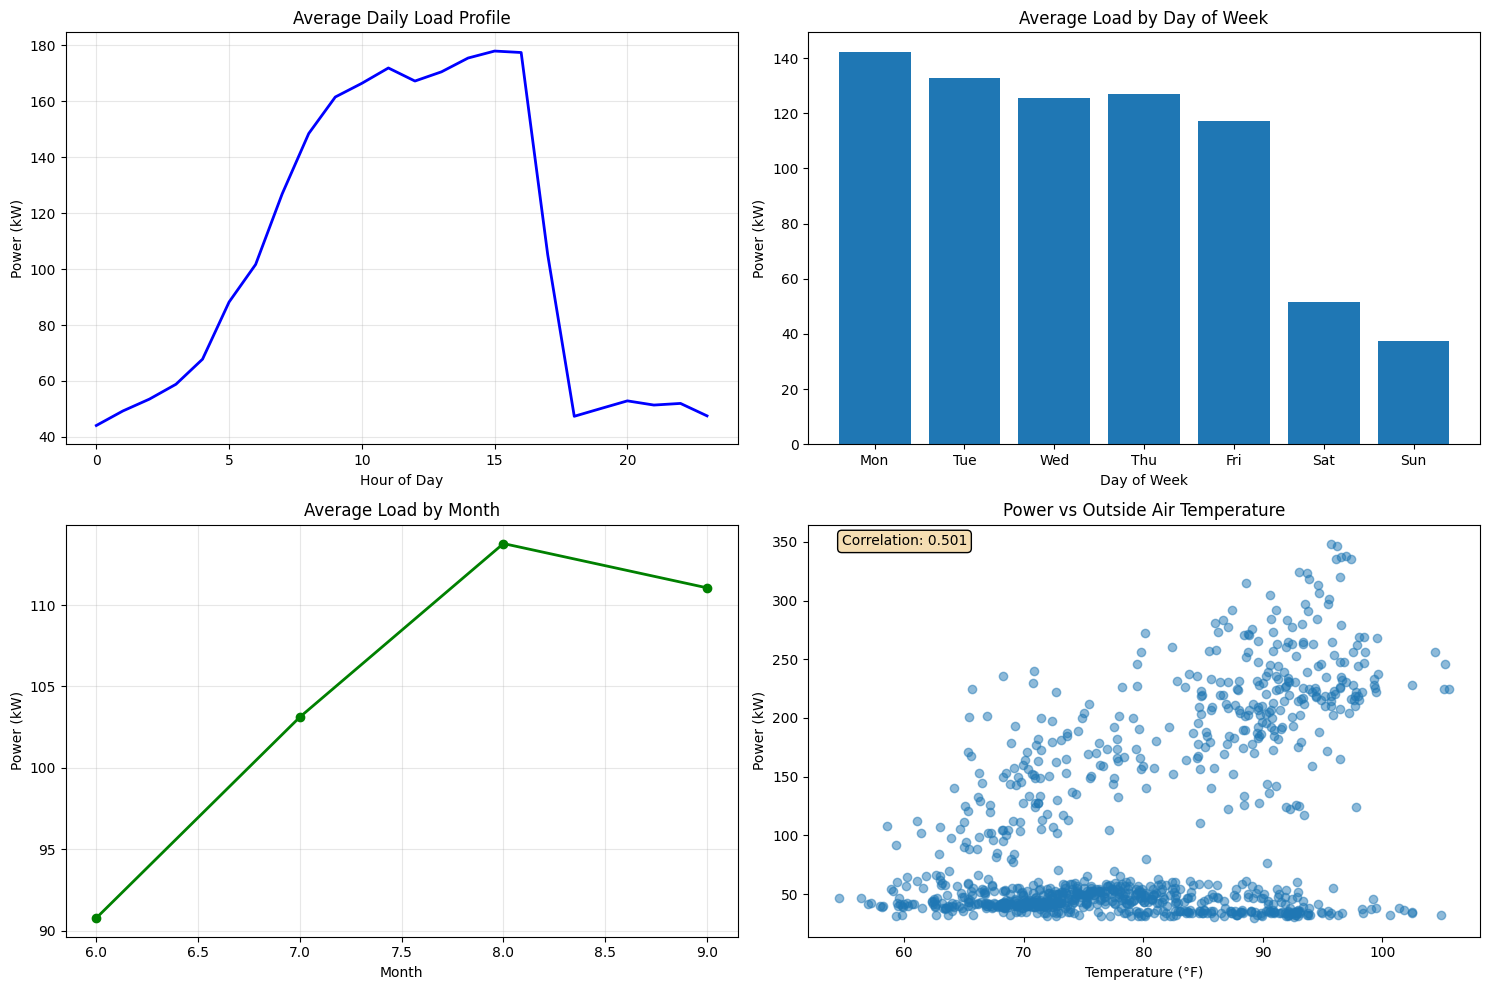

In [23]:
### Load Profile Visualization

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Daily average profile
hourly_avg = data.groupby('hour')['power'].mean()
axes[0,0].plot(hourly_avg.index, hourly_avg.values, 'b-', linewidth=2)
axes[0,0].set_title('Average Daily Load Profile')
axes[0,0].set_xlabel('Hour of Day')
axes[0,0].set_ylabel('Power (kW)')
axes[0,0].grid(True, alpha=0.3)

# Weekly pattern
daily_avg = data.groupby('weekday')['power'].mean()
day_names = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']
axes[0,1].bar(range(7), daily_avg.values)
axes[0,1].set_title('Average Load by Day of Week')
axes[0,1].set_xlabel('Day of Week')
axes[0,1].set_ylabel('Power (kW)')
axes[0,1].set_xticks(range(7))
axes[0,1].set_xticklabels(day_names)

# Monthly pattern
monthly_avg = data.groupby('month')['power'].mean()
axes[1,0].plot(monthly_avg.index, monthly_avg.values, 'go-', linewidth=2)
axes[1,0].set_title('Average Load by Month')
axes[1,0].set_xlabel('Month')
axes[1,0].set_ylabel('Power (kW)')
axes[1,0].grid(True, alpha=0.3)

# Temperature correlation
sample_data = data.sample(n=min(1000, len(data)))
axes[1,1].scatter(sample_data['oat'], sample_data['power'], alpha=0.5)
axes[1,1].set_title('Power vs Outside Air Temperature')
axes[1,1].set_xlabel('Temperature (°F)')
axes[1,1].set_ylabel('Power (kW)')

# Add correlation coefficient
corr = data[['oat', 'power']].corr().iloc[0,1]
axes[1,1].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
               transform=axes[1,1].transAxes, bbox=dict(boxstyle='round', facecolor='wheat'))

plt.tight_layout()
plt.show()

In [27]:
processor.dr_events

,site,event_id,event_type,event_date,take_start_time,take_end_time,shed_start_time,shed_end_time,test_group,date
0,ThreeCarnegiePlaza,1,shift,2008-07-09,7/9/08 6:00,7/9/08 12:00,7/9/08 12:00,7/9/08 18:00,GTA,2008-07-09
1,ThreeCarnegiePlaza,2,shift,2008-07-10,7/10/08 6:00,7/10/08 12:00,7/10/08 12:00,7/10/08 18:00,GTA,2008-07-10
2,ThreeCarnegiePlaza,3,shift,2008-07-21,7/21/08 6:00,7/21/08 12:00,7/21/08 12:00,7/21/08 18:00,GTA,2008-07-21
3,ThreeCarnegiePlaza,4,shift,2008-08-01,8/1/08 6:00,8/1/08 12:00,8/1/08 12:00,8/1/08 18:00,GTA,2008-08-01
4,ThreeCarnegiePlaza,5,shift,2008-08-05,8/5/08 6:00,8/5/08 12:00,8/5/08 12:00,8/5/08 18:00,GTA,2008-08-05
5,ThreeCarnegiePlaza,6,shift,2008-08-06,8/6/08 6:00,8/6/08 12:00,8/6/08 12:00,8/6/08 18:00,GTA,2008-08-06
6,ThreeCarnegiePlaza,7,shift,2008-08-11,8/11/08 6:00,8/11/08 12:00,8/11/08 12:00,8/11/08 18:00,GTA,2008-08-11
7,ThreeCarnegiePlaza,8,shift,2008-08-12,8/12/08 6:00,8/12/08 12:00,8/12/08 12:00,8/12/08 18:00,GTA,2008-08-12
8,ThreeCarnegiePlaza,9,shift,2008-08-27,8/27/08 6:00,8/27/08 12:00,8/27/08 12:00,8/27/08 18:00,GTA,2008-08-27
9,ThreeCarnegiePlaza,10,shift,2008-08-28,8/28/08 6:00,8/28/08 12:00,8/28/08 12:00,8/28/08 18:00,GTA,2008-08-28


In [28]:
## 5. Baseline Model Comparison

# Initialize baseline models and analyzer
baseline_model = BaselineModels(data, site_config)
analyzer = PerformanceAnalyzer(site_config)
visualizer = DRVisualizer()

# Select an example DR event to analyze
example_event_date = '2008-07-09'
dr_events = processor.dr_events

# Create example event info if using synthetic data
if 'dr_events' in locals():
    event_info = dr_events[dr_events['date'] == example_event_date].iloc[0].to_dict()
else:
    # Try to get from processor
    event_info = processor.get_event_by_date(example_event_date)
    if event_info is None:
        print('Check DR events from the processor data')

print(f"Analyzing DR event on {example_event_date}")
print(f"Event type: {event_info['event_type']}")


Analyzing DR event on 2008-07-09
Event type: shift


In [29]:
# ### Method 1: X-of-Y Average Baseline with Adjustment

print("\n" + "="*50)
print("METHOD 1: AVERAGE BASELINE WITH ADJUSTMENT")
print("="*50)

try:
    avg_baseline_result = baseline_model.calculate_average_baseline_with_adjustment(
        event_date=example_event_date,
        x_days=10,
        y_days=10,
        adjustment_limit=0.2
    )
    
    print(f"✅ Calculated average baseline")
    print(f"   Adjustment factor applied: {avg_baseline_result['baseline'].mean() / avg_baseline_result['avg_baseline'].mean():.3f}")
    
    # Calculate validation metrics
    avg_validation = analyzer.calculate_baseline_validation_metrics(
        avg_baseline_result['power'], 
        avg_baseline_result['baseline']
    )
    
    print(f"   Baseline RMSE: {avg_validation.get('RMSE', 0):.1f} kW")
    print(f"   Normalized MAE: {avg_validation.get('NMAE', 0):.1%}")
    
except Exception as e:
    print(f"❌ Error calculating average baseline: {e}")


2025-08-03 21:17:21,272 - INFO - Selected 10 baseline days from 10 candidates
2025-08-03 21:17:21,279 - INFO - Calculated baseline for 2008-07-09 with adjustment factor 0.968



METHOD 1: AVERAGE BASELINE WITH ADJUSTMENT
✅ Calculated average baseline
   Adjustment factor applied: 0.968
   Baseline RMSE: 29.0 kW
   Normalized MAE: 14.8%


In [30]:
### Method 2: Weather-Matched Baseline

print("\n" + "="*50)
print("METHOD 2: WEATHER-MATCHED BASELINE")
print("="*50)

try:
    weather_baseline_result = baseline_model.calculate_weather_matched_baseline(
        event_date=example_event_date,
        x_days=10,
        y_days=10
    )
    
    print(f"✅ Calculated weather-matched baseline")
    
    # Calculate validation metrics
    weather_validation = analyzer.calculate_baseline_validation_metrics(
        weather_baseline_result['power'], 
        weather_baseline_result['baseline']
    )
    
    print(f"   Baseline RMSE: {weather_validation.get('RMSE', 0):.1f} kW")
    print(f"   Normalized MAE: {weather_validation.get('NMAE', 0):.1%}")
    
except Exception as e:
    print(f"❌ Error calculating weather-matched baseline: {e}")


2025-08-03 21:17:52,469 - INFO - Selected 10 baseline days from 10 candidates
2025-08-03 21:17:52,486 - INFO - Matched 2008-07-09 with baseline day 2008-07-08



METHOD 2: WEATHER-MATCHED BASELINE
✅ Calculated weather-matched baseline
   Baseline RMSE: 6.7 kW
   Normalized MAE: 14.3%


In [31]:
### Method 3: OAT Regression Baseline

print("\n" + "="*50)
print("METHOD 3: OAT REGRESSION BASELINE")
print("="*50)

try:
    oat_baseline_result = baseline_model.calculate_oat_regression_baseline(
        event_date=example_event_date,
        training_days=30
    )
    
    print(f"✅ Calculated OAT regression baseline")
    
    # Calculate validation metrics
    oat_validation = analyzer.calculate_baseline_validation_metrics(
        oat_baseline_result['power'], 
        oat_baseline_result['baseline']
    )
    
    print(f"   Baseline RMSE: {oat_validation.get('RMSE', 0):.1f} kW")
    print(f"   Normalized MAE: {oat_validation.get('NMAE', 0):.1%}")
    
except Exception as e:
    print(f"❌ Error calculating OAT regression baseline: {e}")


2025-08-03 21:18:15,875 - INFO - Calculated OAT regression baseline for 2008-07-09



METHOD 3: OAT REGRESSION BASELINE
✅ Calculated OAT regression baseline
   Baseline RMSE: 36.6 kW
   Normalized MAE: 19.9%


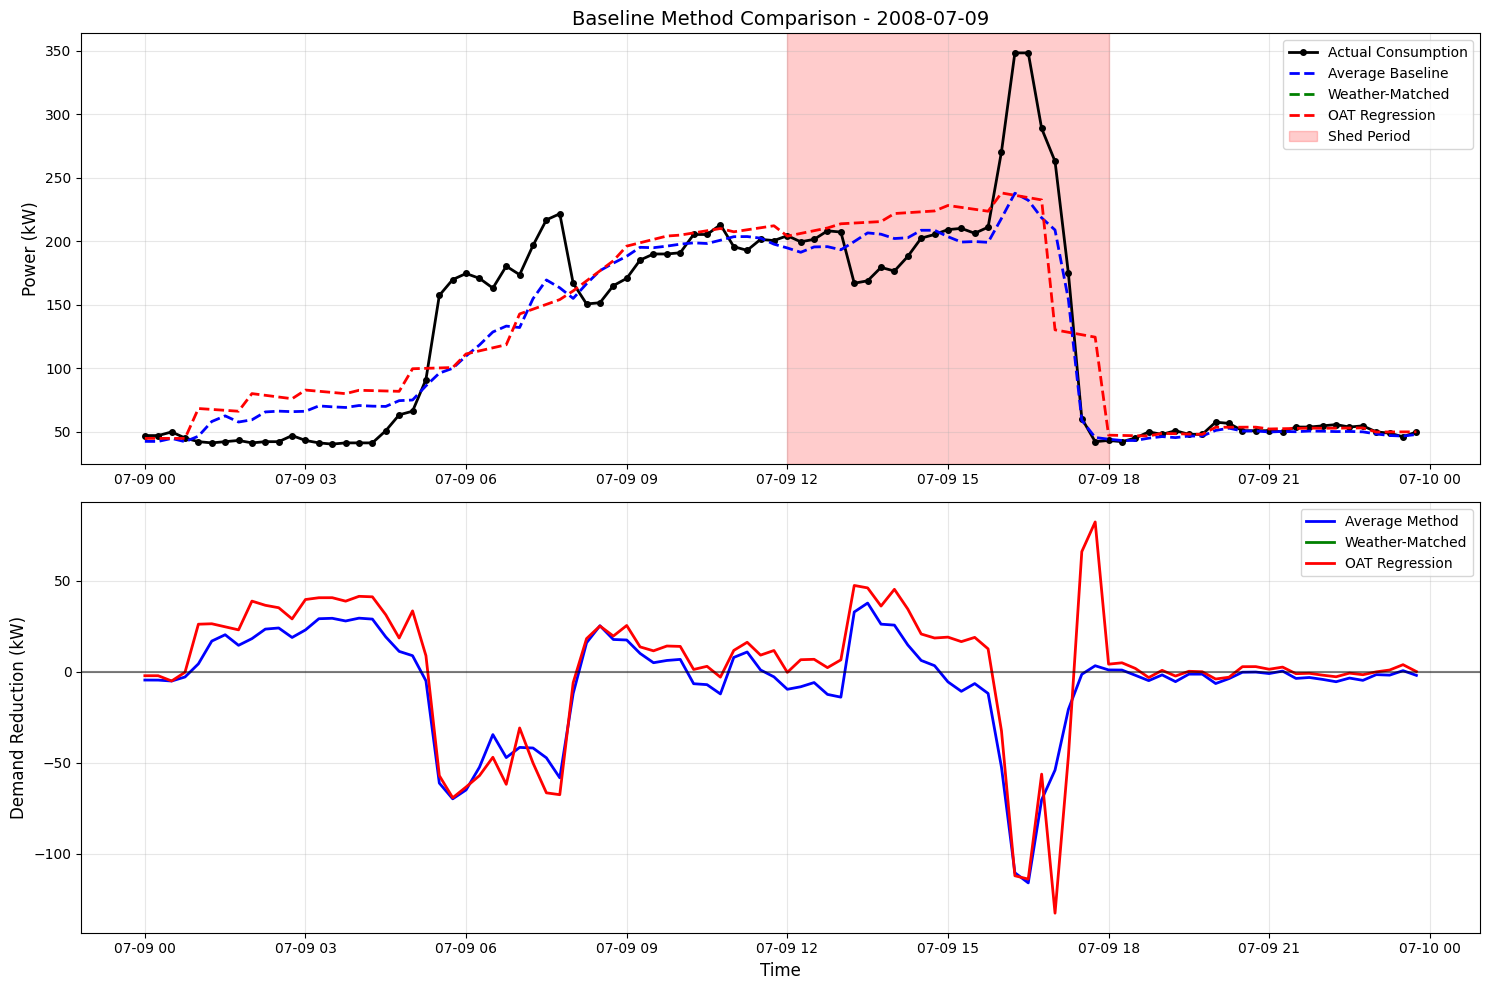

In [34]:
fig, axes = plt.subplots(2, 1, figsize=(15, 10))
    
# Top panel: All baselines vs actual
event_data = data[data['day'] == example_event_date]

axes[0].plot(event_data.index, event_data['power'], 'ko-', 
            label='Actual Consumption', linewidth=2, markersize=4)
axes[0].plot(avg_baseline_result.index, avg_baseline_result['baseline'], 
            'b--', label='Average Baseline', linewidth=2)
axes[0].plot(weather_baseline_result.index, weather_baseline_result['baseline'], 
            'g--', label='Weather-Matched', linewidth=2)
axes[0].plot(oat_baseline_result.index, oat_baseline_result['baseline'], 
            'r--', label='OAT Regression', linewidth=2)

# Highlight DR event period
if event_info['event_type'] in ['shed', 'shift']:
    shed_start = datetime.strptime(event_info['shed_start_time'], '%m/%d/%y %H:%M')
    shed_end = datetime.strptime(event_info['shed_end_time'], '%m/%d/%y %H:%M')
    axes[0].axvspan(shed_start, shed_end, alpha=0.2, color='red', label='Shed Period')

axes[0].set_ylabel('Power (kW)', fontsize=12)
axes[0].set_title(f'Baseline Method Comparison - {example_event_date}', fontsize=14)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Bottom panel: Baseline differences
avg_diff = avg_baseline_result['baseline'] - event_data['power']
weather_diff = weather_baseline_result['baseline'] - event_data['power']
oat_diff = oat_baseline_result['baseline'] - event_data['power']

axes[1].plot(event_data.index, avg_diff, 'b-', label='Average Method', linewidth=2)
axes[1].plot(event_data.index, weather_diff, 'g-', label='Weather-Matched', linewidth=2)
axes[1].plot(event_data.index, oat_diff, 'r-', label='OAT Regression', linewidth=2)
axes[1].axhline(y=0, color='black', linestyle='-', alpha=0.5)

axes[1].set_ylabel('Demand Reduction (kW)', fontsize=12)
axes[1].set_xlabel('Time', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [40]:
weather_baseline_result

,power,oat,baseline
2008-07-09 00:00:00,47.04,74.768,40.32
2008-07-09 00:15:00,47.04,74.093,NaN
2008-07-09 00:30:00,49.92,73.418,NaN
2008-07-09 00:45:00,45.12,72.743,NaN
2008-07-09 01:00:00,42.24,72.068,NaN
...,...,...,...
2008-07-09 22:45:00,54.72,75.209,NaN
2008-07-09 23:00:00,49.92,74.606,NaN
2008-07-09 23:15:00,48.96,74.201,NaN
2008-07-09 23:30:00,46.08,73.796,NaN


2025-08-03 21:22:09,110 - WARNING - posx and posy should be finite values
2025-08-03 21:22:09,135 - WARNING - posx and posy should be finite values



DEMAND RESPONSE PERFORMANCE ANALYSIS

Performance Metrics Comparison:
--------------------------------------------------
                      shed_avg_kW  shed_avg_pct  shed_avg_wft2  peak_demand_intensity_wft2  net_energy_change_pct
Average + Adjustment       -14.60         -6.31          -0.17                        2.84                   4.60
Weather-Matched               NaN           NaN            NaN                        0.48               29690.48
OAT Regression              -0.16          0.38          -0.00                        2.85                  -1.44


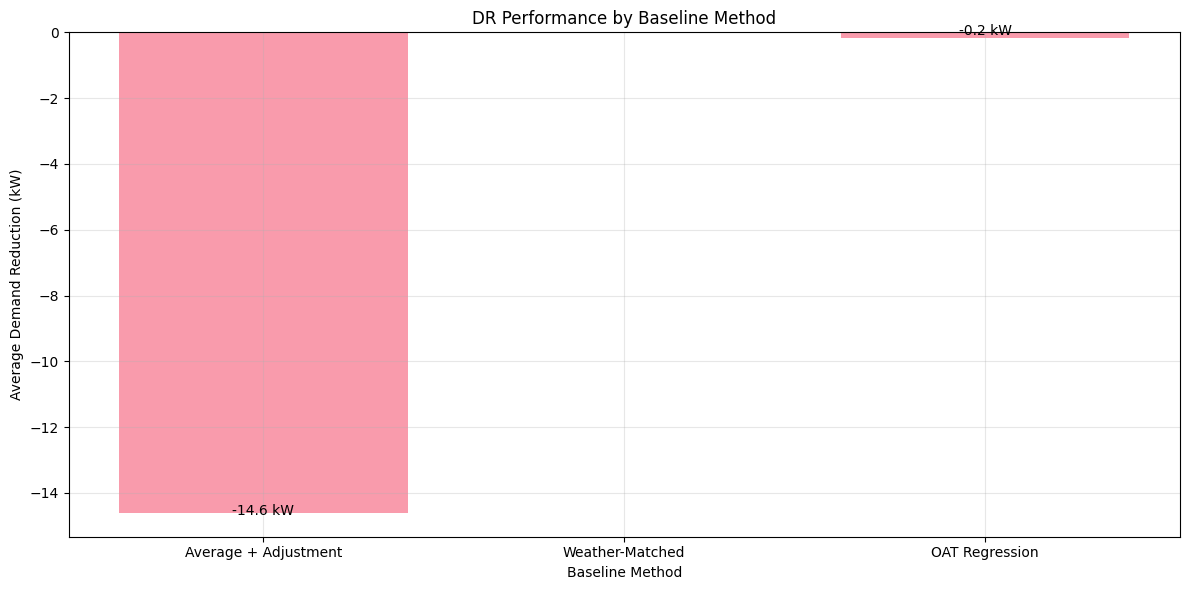

In [36]:
# ## 6. Performance Metrics Analysis

print("\n" + "="*60)
print("DEMAND RESPONSE PERFORMANCE ANALYSIS")
print("="*60)

# Calculate performance metrics for each baseline method
methods = {}

avg_metrics = analyzer.calculate_dr_event_metrics(avg_baseline_result, event_info)
methods['Average + Adjustment'] = avg_metrics

weather_metrics = analyzer.calculate_dr_event_metrics(weather_baseline_result, event_info)
methods['Weather-Matched'] = weather_metrics

oat_metrics = analyzer.calculate_dr_event_metrics(oat_baseline_result, event_info)
methods['OAT Regression'] = oat_metrics

# if 'avg_baseline_result' in locals():
#     avg_metrics = analyzer.calculate_dr_event_metrics(avg_baseline_result, event_info)
#     methods['Average + Adjustment'] = avg_metrics

# if 'weather_baseline_result' in locals():
#     weather_metrics = analyzer.calculate_dr_event_metrics(weather_baseline_result, event_info)
#     methods['Weather-Matched'] = weather_metrics

# if 'oat_baseline_result' in locals():
#     oat_metrics = analyzer.calculate_dr_event_metrics(oat_baseline_result, event_info)
#     methods['OAT Regression'] = oat_metrics

# Create performance comparison table
if methods:
    metrics_df = pd.DataFrame(methods).T
    
    # Select key metrics for comparison
    key_metrics = [
        'shed_avg_kW', 'shed_avg_pct', 'shed_avg_wft2',
        'peak_demand_intensity_wft2', 'net_energy_change_pct'
    ]
    
    available_metrics = [m for m in key_metrics if m in metrics_df.columns]
    
    if available_metrics:
        comparison_table = metrics_df[available_metrics].round(2)
        
        print("\nPerformance Metrics Comparison:")
        print("-" * 50)
        print(comparison_table.to_string())
        
        # Visualize key metrics
        fig, ax = plt.subplots(figsize=(12, 6))
        
        x_pos = np.arange(len(methods))
        
        if 'shed_avg_kW' in comparison_table.columns:
            values = comparison_table['shed_avg_kW'].values
            bars = ax.bar(x_pos, values, alpha=0.7)
            
            # Add value labels on bars
            for i, (bar, val) in enumerate(zip(bars, values)):
                height = bar.get_height()
                ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                       f'{val:.1f} kW', ha='center', va='bottom')
            
            ax.set_xlabel('Baseline Method')
            ax.set_ylabel('Average Demand Reduction (kW)')
            ax.set_title('DR Performance by Baseline Method')
            ax.set_xticks(x_pos)
            ax.set_xticklabels(methods.keys())
            ax.grid(True, alpha=0.3)
            
            plt.tight_layout()
            plt.show()


2025-08-03 21:26:31,300 - INFO - Selected 10 baseline days from 10 candidates
2025-08-03 21:26:31,304 - INFO - Calculated baseline for 2008-08-01 with adjustment factor 0.962
2025-08-03 21:26:31,314 - INFO - Selected 10 baseline days from 10 candidates
2025-08-03 21:26:31,320 - INFO - Calculated baseline for 2008-08-05 with adjustment factor 0.985
2025-08-03 21:26:31,327 - INFO - Selected 10 baseline days from 10 candidates
2025-08-03 21:26:31,329 - INFO - Calculated baseline for 2008-08-06 with adjustment factor 0.946



PORTFOLIO ANALYSIS

Analyzed 3 DR events
Average demand reduction: 28.7 ± 10.1 kW
Best performance: 37.8 kW on 2008-08-01
Range: 17.8 to 37.8 kW


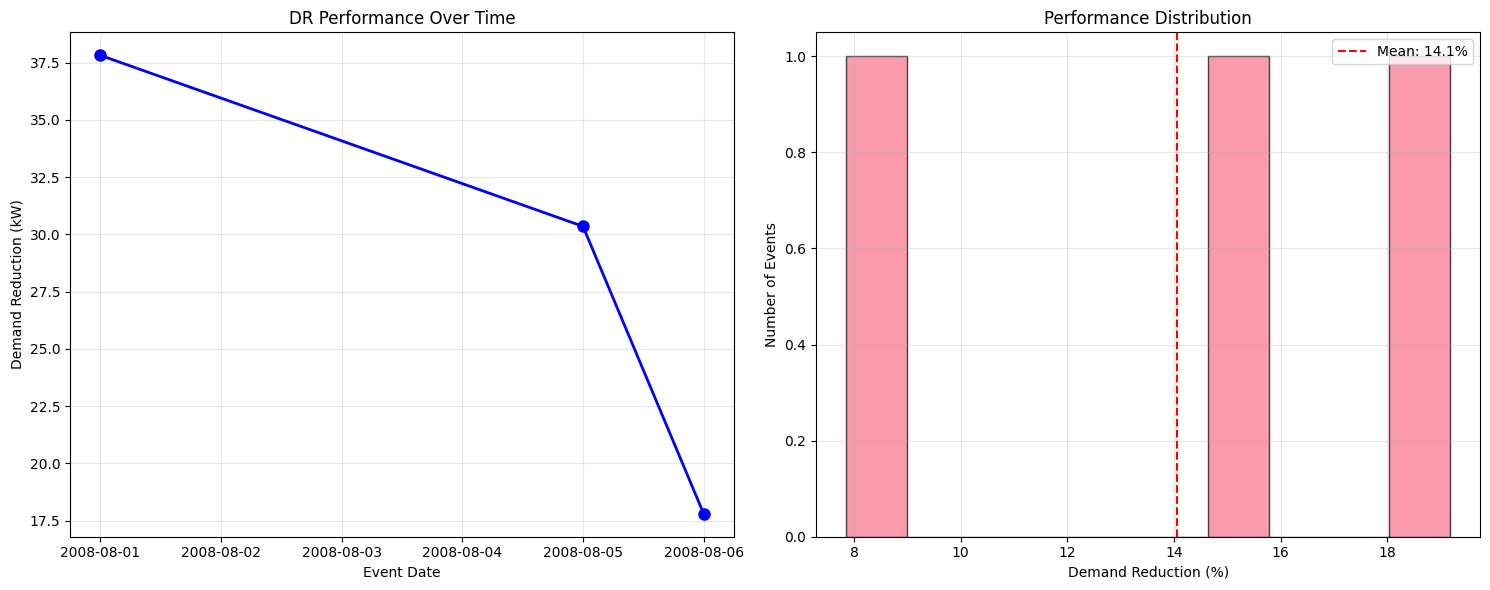

In [41]:
## 7. Advanced Analysis: Multiple Events

print("\n" + "="*50)
print("PORTFOLIO ANALYSIS")
print("="*50)

# Analyze multiple DR events if available
event_dates = ['2008-08-01', '2008-08-05', '2008-08-06']
portfolio_results = []

for event_date in event_dates:
    if event_date in data['day'].values:
        try:
            # Get event info
            if 'dr_events' in locals():
                event = dr_events[dr_events['date'] == event_date].iloc[0].to_dict()
            else:
                event = {
                    'event_date': event_date,
                    'date': event_date,
                    'event_type': 'shed',
                    'shed_start_time': f'{event_date[-2:]}/15/19 14:00',
                    'shed_end_time': f'{event_date[-2:]}/15/19 18:00'
                }
            
            # Calculate baseline
            baseline_result = baseline_model.calculate_average_baseline_with_adjustment(event_date)
            
            # Calculate metrics
            metrics = analyzer.calculate_dr_event_metrics(baseline_result, event)
            metrics['event_date'] = event_date
            metrics['event_type'] = event.get('event_type', 'shed')
            
            portfolio_results.append(metrics)
            
        except Exception as e:
            print(f"⚠️  Could not analyze event on {event_date}: {e}")

if portfolio_results:
    portfolio_df = pd.DataFrame(portfolio_results)
    
    print(f"\nAnalyzed {len(portfolio_results)} DR events")
    
    # Summary statistics
    if 'shed_avg_kW' in portfolio_df.columns:
        print(f"Average demand reduction: {portfolio_df['shed_avg_kW'].mean():.1f} ± {portfolio_df['shed_avg_kW'].std():.1f} kW")
        print(f"Best performance: {portfolio_df['shed_avg_kW'].max():.1f} kW on {portfolio_df.loc[portfolio_df['shed_avg_kW'].idxmax(), 'event_date']}")
        print(f"Range: {portfolio_df['shed_avg_kW'].min():.1f} to {portfolio_df['shed_avg_kW'].max():.1f} kW")
    
    # Portfolio visualization
    if len(portfolio_results) > 1:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Event performance over time
        if 'shed_avg_kW' in portfolio_df.columns:
            portfolio_df['event_date_dt'] = pd.to_datetime(portfolio_df['event_date'])
            axes[0].plot(portfolio_df['event_date_dt'], portfolio_df['shed_avg_kW'], 'bo-', linewidth=2, markersize=8)
            axes[0].set_xlabel('Event Date')
            axes[0].set_ylabel('Demand Reduction (kW)')
            axes[0].set_title('DR Performance Over Time')
            axes[0].grid(True, alpha=0.3)
        
        # Performance distribution
        if 'shed_avg_pct' in portfolio_df.columns:
            axes[1].hist(portfolio_df['shed_avg_pct'], bins=10, alpha=0.7, edgecolor='black')
            axes[1].axvline(portfolio_df['shed_avg_pct'].mean(), color='red', linestyle='--', 
                           label=f'Mean: {portfolio_df["shed_avg_pct"].mean():.1f}%')
            axes[1].set_xlabel('Demand Reduction (%)')
            axes[1].set_ylabel('Number of Events')
            axes[1].set_title('Performance Distribution')
            axes[1].legend()
            axes[1].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()


In [42]:
## 8. Best Practices and Recommendations

print("\n" + "="*60)
print("BEST PRACTICES & RECOMMENDATIONS")
print("="*60)

# Data quality assessment
data_quality_score = 0
recommendations = []

# Check data completeness
missing_power_pct = data['power'].isna().mean()
if missing_power_pct < 0.01:
    data_quality_score += 25
    print("✅ Excellent data completeness (<1% missing)")
elif missing_power_pct < 0.05:
    data_quality_score += 20
    print("✅ Good data completeness (<5% missing)")
else:
    print(f"⚠️  Data completeness concern: {missing_power_pct:.1%} missing power data")
    recommendations.append("Improve data collection reliability")

# Check temporal coverage
date_range_days = (data.index.max() - data.index.min()).days
if date_range_days >= 365:
    data_quality_score += 25
    print("✅ Excellent temporal coverage (≥1 year)")
elif date_range_days >= 180:
    data_quality_score += 20
    print("✅ Good temporal coverage (≥6 months)")
else:
    print(f"⚠️  Limited temporal coverage: {date_range_days} days")
    recommendations.append("Collect at least 12 months of historical data")

# Check baseline day availability
valid_days_ratio = data['valid_dates'].mean()
if valid_days_ratio >= 0.6:
    data_quality_score += 25
    print("✅ Excellent baseline day availability")
elif valid_days_ratio >= 0.4:
    data_quality_score += 20
    print("✅ Good baseline day availability")
else:
    print(f"⚠️  Limited baseline days: {valid_days_ratio:.1%} of data")
    recommendations.append("Minimize DR events and holidays for better baselines")

# Check weather correlation
weather_corr = abs(data[['power', 'oat']].corr().iloc[0,1])
if weather_corr >= 0.7:
    data_quality_score += 25
    print("✅ Strong weather correlation - OAT models recommended")
elif weather_corr >= 0.4:
    data_quality_score += 20
    print("✅ Moderate weather correlation")
else:
    print(f"⚠️  Weak weather correlation: {weather_corr:.3f}")
    recommendations.append("Consider alternative baseline methods")

print(f"\nOverall Data Quality Score: {data_quality_score}/100")

if recommendations:
    print("\nRecommendations for improvement:")
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")

# Baseline method recommendations
print(f"\nBaseline Method Recommendations:")
print("=" * 40)

if weather_corr >= 0.6:
    print("🎯 Primary: OAT Regression Baseline")
    print("   - Strong weather correlation supports statistical modeling")
    print("   - Best for HVAC-dominated buildings")
    print("🔄 Secondary: Average + Adjustment")
    print("   - Good for validation and regulatory compliance")
else:
    print("🎯 Primary: Average Baseline with Adjustment")
    print("   - Industry standard method")
    print("   - Robust for buildings with stable patterns")
    print("🔄 Secondary: Weather-Matched Baseline")
    print("   - Good alternative for moderate weather sensitivity")

print(f"\n💡 General Recommendations:")
print("• Use multiple baseline methods for validation")
print("• Monitor baseline accuracy on non-event days")
print("• Document adjustment factors and validation metrics")
print("• Consider seasonal variations in baseline selection")
print("• Implement real-time monitoring for event performance")



BEST PRACTICES & RECOMMENDATIONS
✅ Excellent data completeness (<1% missing)
⚠️  Limited temporal coverage: 121 days
✅ Excellent baseline day availability
✅ Moderate weather correlation

Overall Data Quality Score: 70/100

Recommendations for improvement:
1. Collect at least 12 months of historical data

Baseline Method Recommendations:
🎯 Primary: Average Baseline with Adjustment
   - Industry standard method
   - Robust for buildings with stable patterns
🔄 Secondary: Weather-Matched Baseline
   - Good alternative for moderate weather sensitivity

💡 General Recommendations:
• Use multiple baseline methods for validation
• Monitor baseline accuracy on non-event days
• Document adjustment factors and validation metrics
• Consider seasonal variations in baseline selection
• Implement real-time monitoring for event performance


In [44]:
## 9. Summary Report

print("\n" + "="*60)
print("EXECUTIVE SUMMARY")
print("="*60)

if 'avg_metrics' in locals():
    print(f"Building: {site_config['site_id']}")
    print(f"Analysis Period: {data.index.min().date()} to {data.index.max().date()}")
    print(f"Floor Area: {site_config['floor_area']} sq ft")
    
    print(f"\nExample Event Performance ({example_event_date}):")
    print(f"• Event Type: {event_info.get('event_type', 'Unknown').title()}")
    
    if 'shed_avg_kW' in avg_metrics:
        shed_kw = avg_metrics['shed_avg_kW']
        shed_pct = avg_metrics.get('shed_avg_pct', 0)
        shed_intensity = avg_metrics.get('shed_avg_wft2', 0)
        
        print(f"• Average Demand Reduction: {shed_kw:.1f} kW ({shed_pct:.1f}%)")
        print(f"• Demand Intensity Reduction: {shed_intensity:.2f} W/ft²")
        
        # Calculate annual savings estimate
        if shed_kw > 0:
            annual_events = 50  # Estimate
            annual_savings_kwh = shed_kw * 4 * annual_events  # 4-hour events
            cost_per_kwh = 0.15  # Example rate
            annual_savings_cost = annual_savings_kwh * cost_per_kwh
            
            print(f"• Estimated Annual Energy Savings: {annual_savings_kwh:,.0f} kWh")
            print(f"• Estimated Annual Cost Savings: ${annual_savings_cost:,.0f}")
    
    print(f"\nData Quality Assessment: {data_quality_score}/100")
    
    if data_quality_score >= 80:
        print("✅ Excellent data quality - Results are highly reliable")
    elif data_quality_score >= 60:
        print("✅ Good data quality - Results are reliable with minor limitations")
    else:
        print("⚠️  Data quality needs improvement - Results should be interpreted cautiously")


EXECUTIVE SUMMARY
Building: ThreeCarnegiePlaza
Analysis Period: 2008-06-01 to 2008-09-30
Floor Area: 83698 sq ft

Example Event Performance (2008-07-09):
• Event Type: Shift
• Average Demand Reduction: -14.6 kW (-6.3%)
• Demand Intensity Reduction: -0.17 W/ft²

Data Quality Assessment: 70/100
✅ Good data quality - Results are reliable with minor limitations
